In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
# The theoretical capacity of the cells modelled by Marinescu-type 0D models are given
# by cth = (3 * ne * F * S8 / (ns8 * Ms) + ne * F * S4/ (ns4 * Ms)) / 3600

Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

print("Theoretical Capacity = %2.2f Ah" %(cth))

Theoretical Capacity = 3.37 Ah


In [3]:
# let us take the theoretical capacity down to the level of the 0.211 Ah battery from Hunt.

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# check that the new cell capacity is same as Hunt's
cth = ((3 * n4 * F * S8_initial_frac*m_s_hunt / (ns8 * Ms)) + (n4 * F * S4_initial_frac*m_s_hunt / (ns4 * Ms))) / 3600
print("Theoretical Capacity = %2.3f Ah" %(cth))

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

Theoretical Capacity = 0.211 Ah


In [4]:
S8_initial_hunt = S8_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4
initial_data = (V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt)

In [5]:
def hua_2019_alg_discharge_function(temp):
    
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = initial_data
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 2.75e-5,
        "Shuttle rate coefficient during discharge [s-1]": 0.0,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": 298
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,1000))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = t, Ah, V, S8, S4, S2, S1, Sp, Tc
            return data
            
            break
        except:
            pass

In [6]:
temp_array = list(np.add([20,30,40], 272.15))

discharge_data = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in temp_array)

Text(0.5, 1.0, 'Temperature Comparison of Hua 2019 model voltages (Tc alg) with 0.211 Ah capacity and .2C discharge')

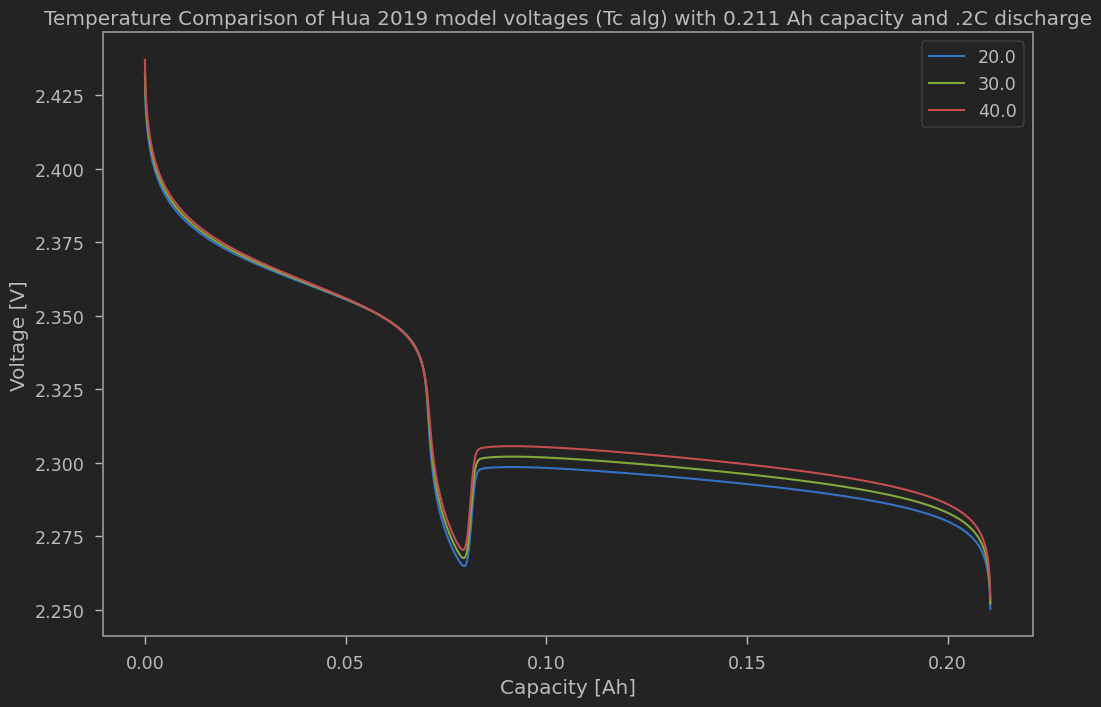

In [7]:
for sub_data in discharge_data:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(np.add(temp_array,-272.15))
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg) with 0.211 Ah capacity and .2C discharge")


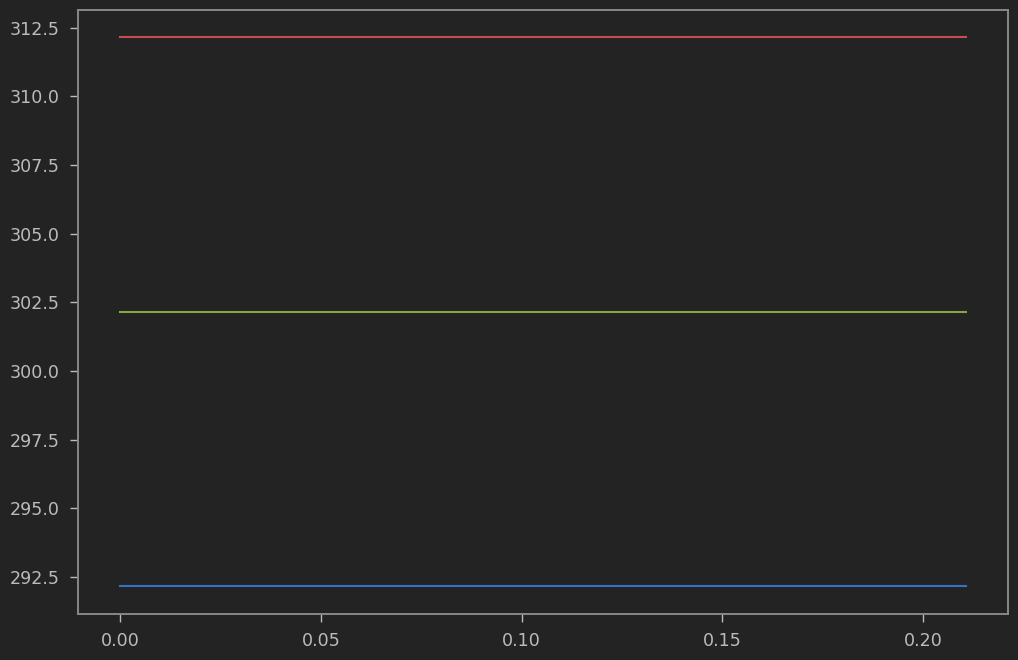

In [8]:
for sub_data in discharge_data:
    voltage = sub_data[-1]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)


In [9]:
for sub_data in discharge_data:
    print(min(sub_data[-1]))
    print(max(sub_data[-1]))

292.15
292.15
302.15
302.15
312.15
312.15


Text(0, 0.5, 'Value')

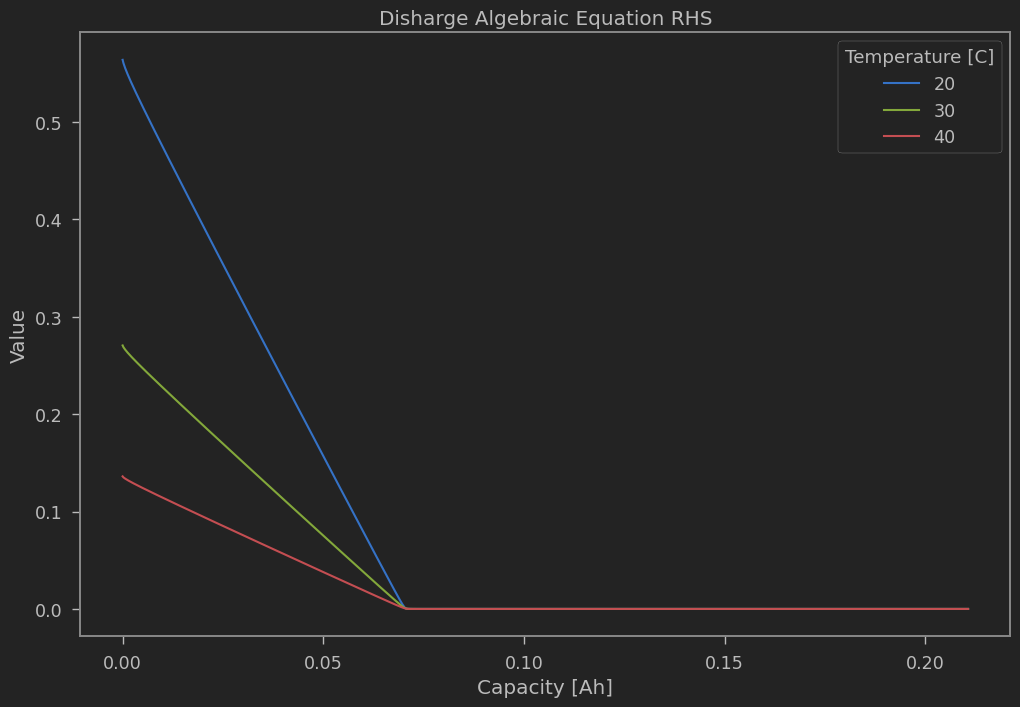

In [17]:
for data in discharge_data:
    temp = data[-1]
    V = data[2]
    S8 = data[3]
    Ah = data[1]
    k_s = (2e-4)*np.exp( (8.9712*6.0221*1e3)*( (1/temp) - (1/298) )/8.3145  )
    coef = (9.649e4)/(1.68*1.28*10)
    
    plt.plot(Ah, coef*k_s*S8*V)
plt.legend(['20','30','40'],title= 'Temperature [C]')
plt.title('Disharge Algebraic Equation RHS')
plt.xlabel('Capacity [Ah]')
plt.ylabel('Value')

In [9]:
# There is no difference in the discharge curves because ks = 0 on discharge
# This implies that, since Tc=Ta, the temperature algebraic condition is
# always satisfied. What we want is to have the shuttle change due to 
# varying species concentration. Therefore, we are going to try several small
# discharge shuttle values to check how they effect the discharge curve. 

def hua_2019_alg_discharge_function_ks(temp):
    
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = initial_data
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.00002,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": 298
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,100000))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = t, Ah, V, S8, S4, S2, S1, Sp, Tc
            return data
            
            break
        except:
            pass

In [10]:
temp_array = list(np.add([20,30,40], 272.15))

discharge_data_ks_low = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function_ks)(i) for i in temp_array)

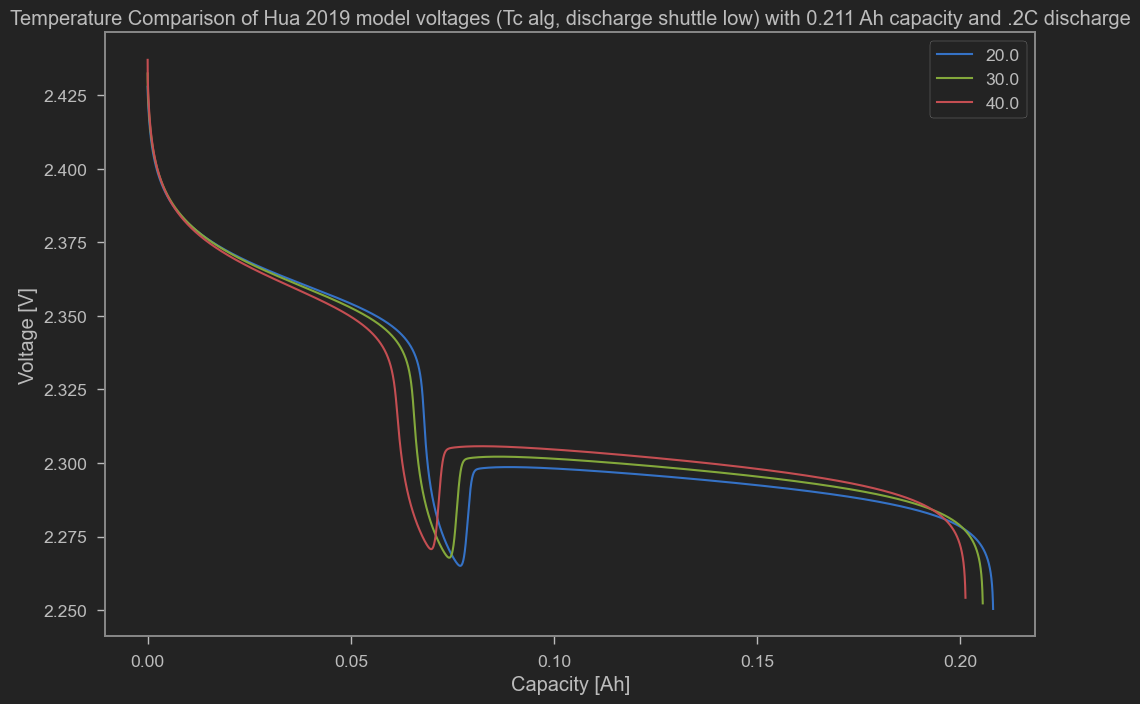

In [15]:
for sub_data in discharge_data_ks_low:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(np.add(temp_array,-272.15))
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, discharge shuttle low) with 0.211 Ah capacity and .2C discharge")
notify

In [12]:
def hua_2019_alg_discharge_function_ks(temp):
    
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = initial_data
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": temp
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,100000))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = t, Ah, V, S8, S4, S2, S1, Sp, Tc
            return data
            
            break
        except:
            pass

In [13]:
temp_array = list(np.add([20,30,40], 272.15))

discharge_data_ks_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function_ks)(i) for i in temp_array)

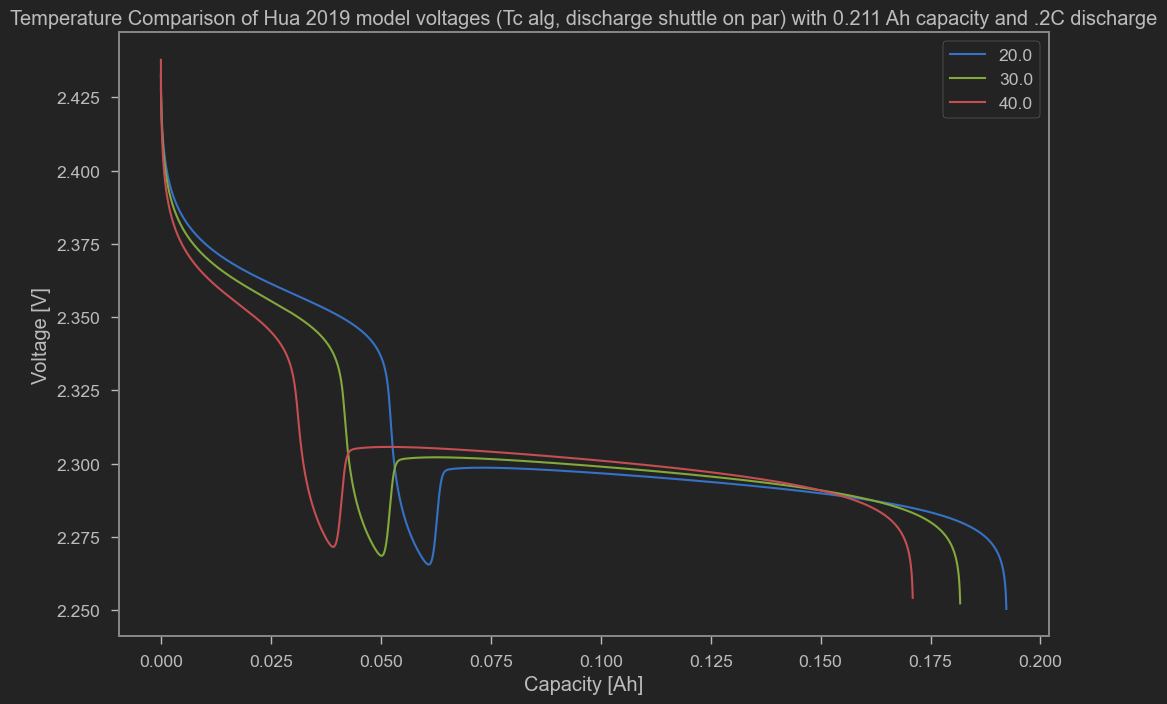

In [16]:
for sub_data in discharge_data_ks_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(np.add(temp_array,-272.15))
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, discharge shuttle on par) with 0.211 Ah capacity and .2C discharge")
notify

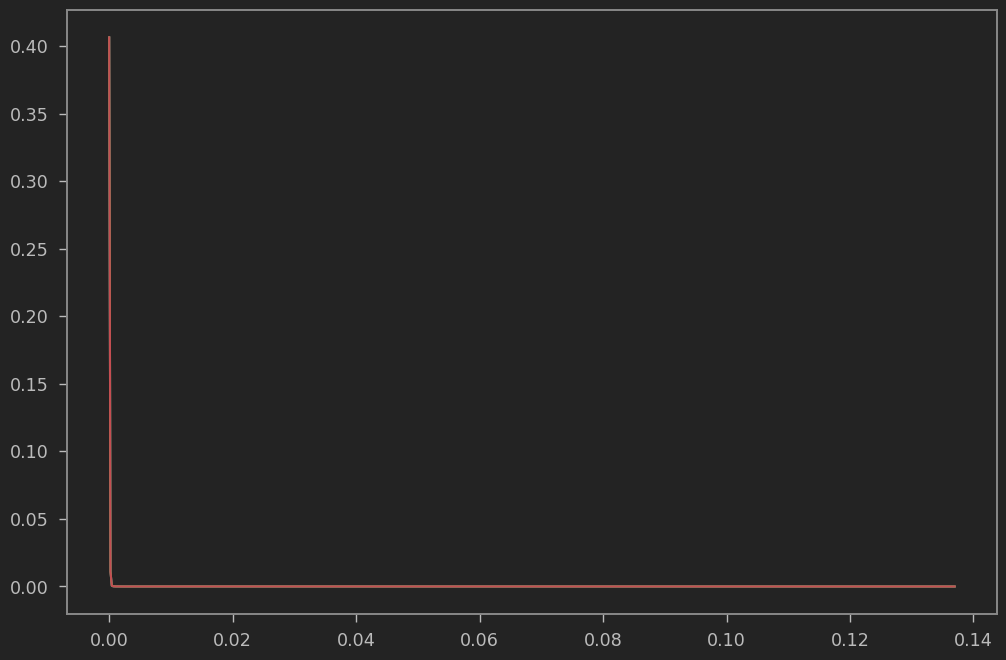

In [35]:
for sub_data in discharge_data_ks_high:
    voltage = sub_data[3]*sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)

In [41]:
discharge_data[0][2]

array([2.43052218, 2.4279399 , 2.42785974, ..., 2.25169591, 2.25156346,
       2.25148208])

In [21]:
def ic_grab(data, ref =-10):
    t, Ah, V, S8, S4, S2, S1, Sp, Tc = data
    V_initial = V[ref]
    S8_initial = S8[ref]
    S4_initial = S4[ref]
    S2_initial = S2[ref]
    S1_initial = S1[ref]
    Sp_initial = Sp[ref]
    
    return V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial

In [31]:
def hua_2019_charge_function_alg(inputs):
    
    data, temp = inputs
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = ic_grab(data, -10)
    
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": -0.0211,
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.0,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": temp
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,100000))
            # extract data
            t = sim.solution.t
            Ah = abs(-0.0211)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = t, Ah, V, S8, S4, S2, S1, Sp, Tc
            return data
            
            break
        except:
            pass

In [32]:
temp_array = list(np.add([20,30,40], 272.15))
inputs = [(discharge_data[0], temp_array[0]),
          (discharge_data[1], temp_array[1]),
          (discharge_data[2], temp_array[2])]
charge_data_2019 = Parallel(n_jobs=-1)(delayed(hua_2019_charge_function_alg)(i) for i in inputs)

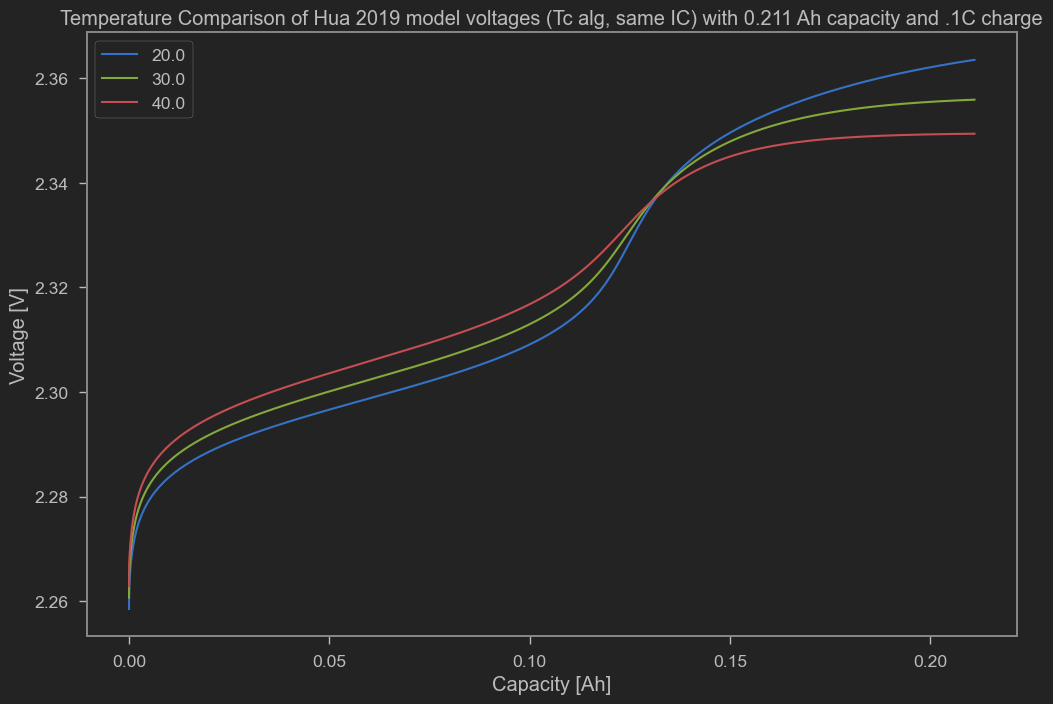

In [33]:
for sub_data in charge_data_2019:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(np.add(temp_array,-272.15))
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, same IC) with 0.211 Ah capacity and .1C charge")
notify

In [34]:
temp_array = list(np.add([20,30,40], 272.15))
inputs = [(discharge_data_ks_low[0], temp_array[0]),
          (discharge_data_ks_low[1], temp_array[1]),
          (discharge_data_ks_low[2], temp_array[2])]
charge_data_from_discharge_ks_2019 = Parallel(n_jobs=-1)(delayed(hua_2019_charge_function_alg)(i) for i in inputs)

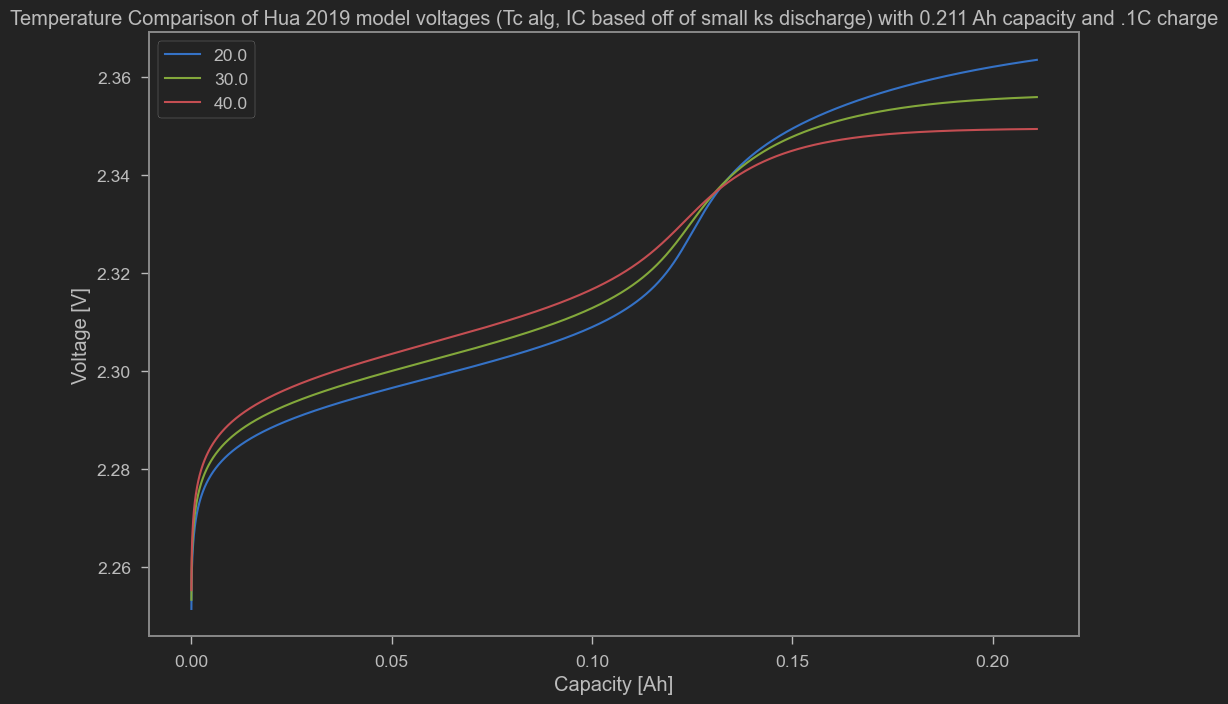

In [35]:
for sub_data in charge_data_from_discharge_ks_2019:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(np.add(temp_array,-272.15))
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, IC based off of small ks discharge) with 0.211 Ah capacity and .1C charge")
notify

In [105]:
def hua_2019_alg_discharge_function(inputs):
    
    k_s_disharge, S_star, k_p = inputs
    temp = 272.15 + 30#20 # indicating the 20 degree Celcius experiment
    
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = initial_data
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 2.75e-5,
        "Shuttle rate coefficient during discharge [s-1]": k_s_discharge,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": 298,
        "Precipitation rate [s-1]": k_p,
        "S saturation mass [g]": S_star
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,10000))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = t, Ah, V, S8, S4, S2, S1, Sp, Tc, S_star, k_p
            return data
            
            break
        except:
            pass

In [97]:
k_s_discharge = 2.75e-6
input_array1 = [(k_s_discharge,0.0001, 500),(k_s_discharge,0.0001, 100),(k_s_discharge,0.0001, 10)]
input_array2 = [(k_s_discharge,0.005, 500),(k_s_discharge,0.005, 100),(k_s_discharge,0.005, 10)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array1)

Text(0.5, 1.0, 'Hua 2019 model voltages (Tc alg, k_s = 2.75e-06) with 0.211 Ah capacity and .2C discharge')

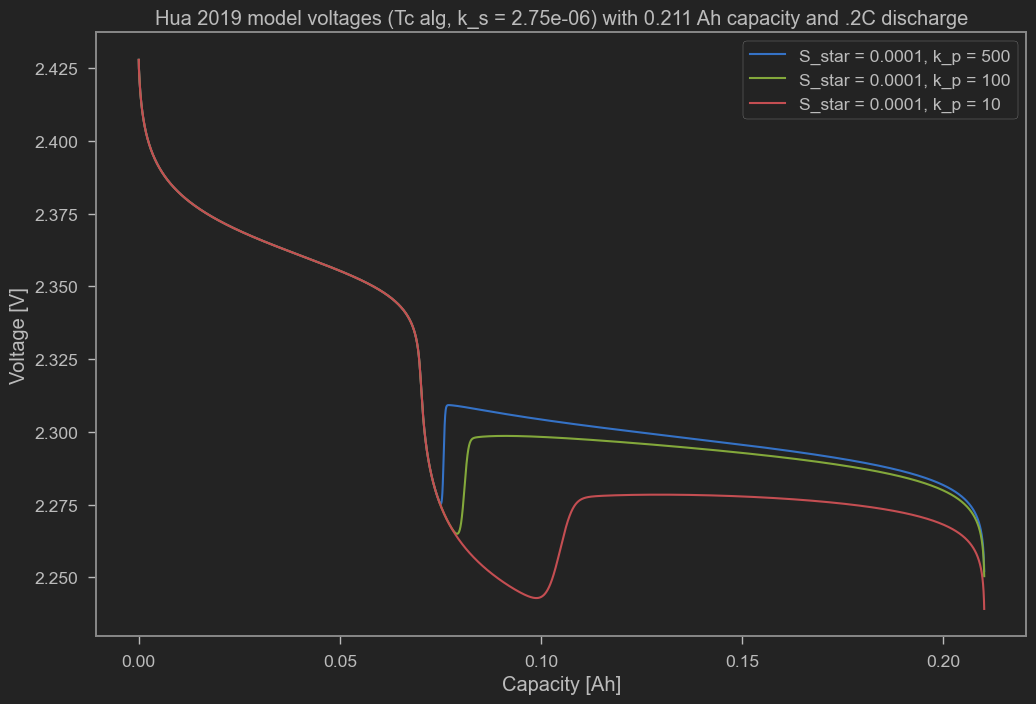

In [98]:
legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))

In [99]:
k_s_discharge = 2.75e-6
input_array1 = [(k_s_discharge,0.0001, 500),(k_s_discharge,0.0001, 100),(k_s_discharge,0.0001, 10)]
input_array2 = [(k_s_discharge,0.005, 500),(k_s_discharge,0.005, 100),(k_s_discharge,0.005, 10)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array2)

Text(0.5, 1.0, 'Hua 2019 model voltages (Tc alg, k_s = 2.75e-06) with 0.211 Ah capacity and .2C discharge')

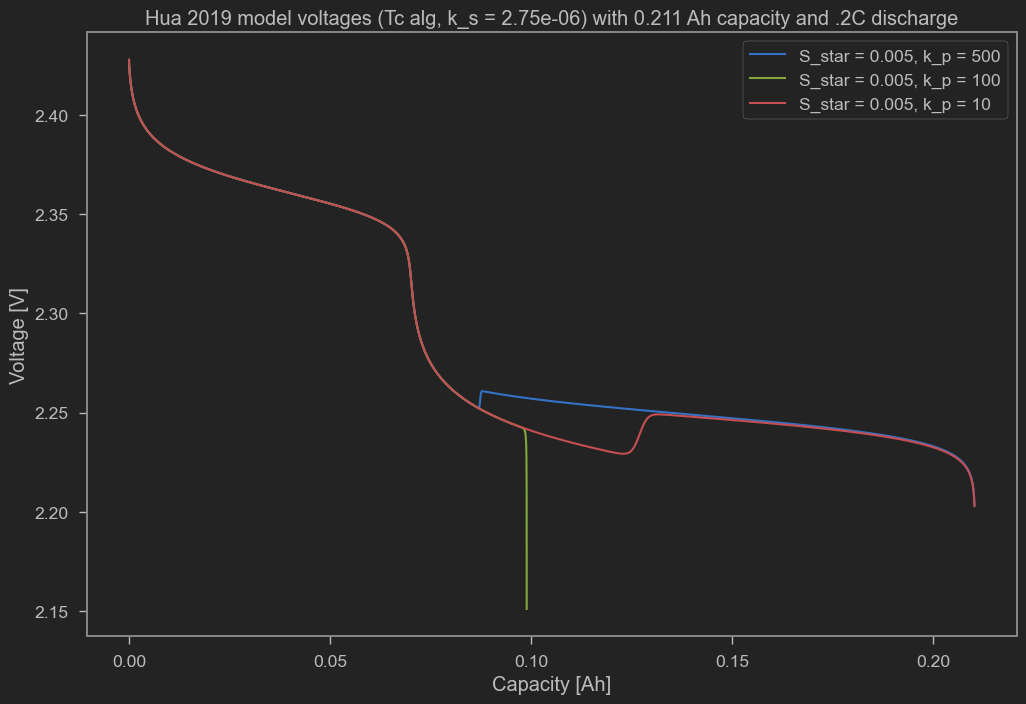

In [100]:
legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))

Text(0.5, 1.0, 'Hua 2019 model voltages (Tc alg, k_s = 2.75e-05) with 0.211 Ah capacity and .2C discharge')

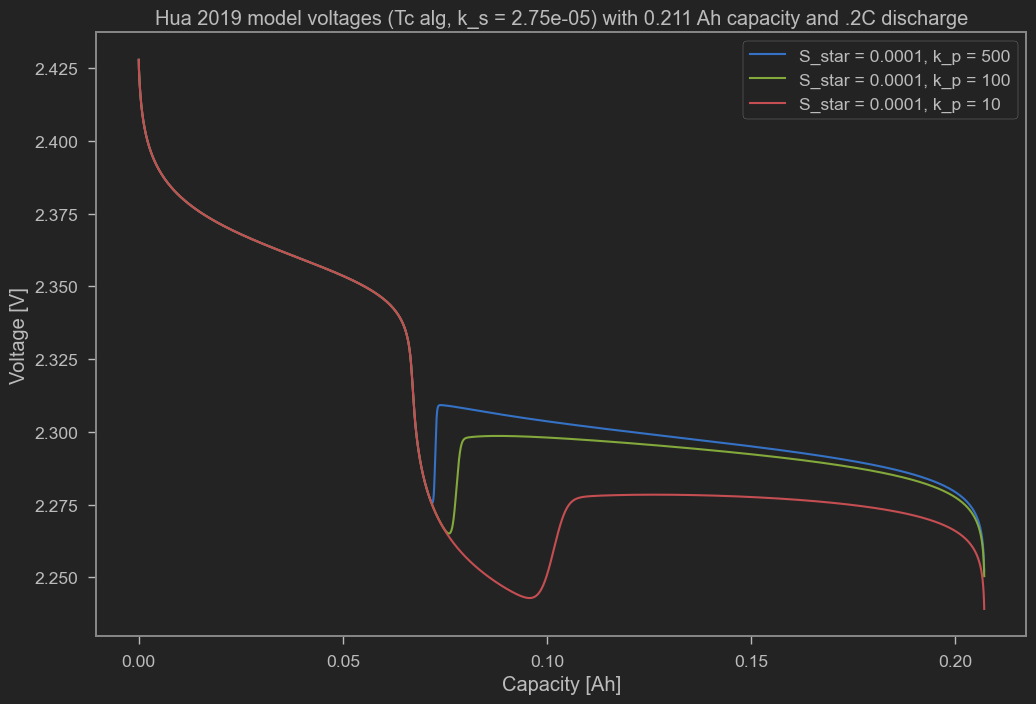

In [102]:
k_s_discharge = 2.75e-5
input_array1 = [(k_s_discharge,0.0001, 500),(k_s_discharge,0.0001, 100),(k_s_discharge,0.0001, 10)]
input_array2 = [(k_s_discharge,0.005, 500),(k_s_discharge,0.005, 100),(k_s_discharge,0.005, 10)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array1)

legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))

Text(0.5, 1.0, 'Hua 2019 model voltages (Tc alg, k_s = 2.75e-05) with 0.211 Ah capacity and .2C discharge')

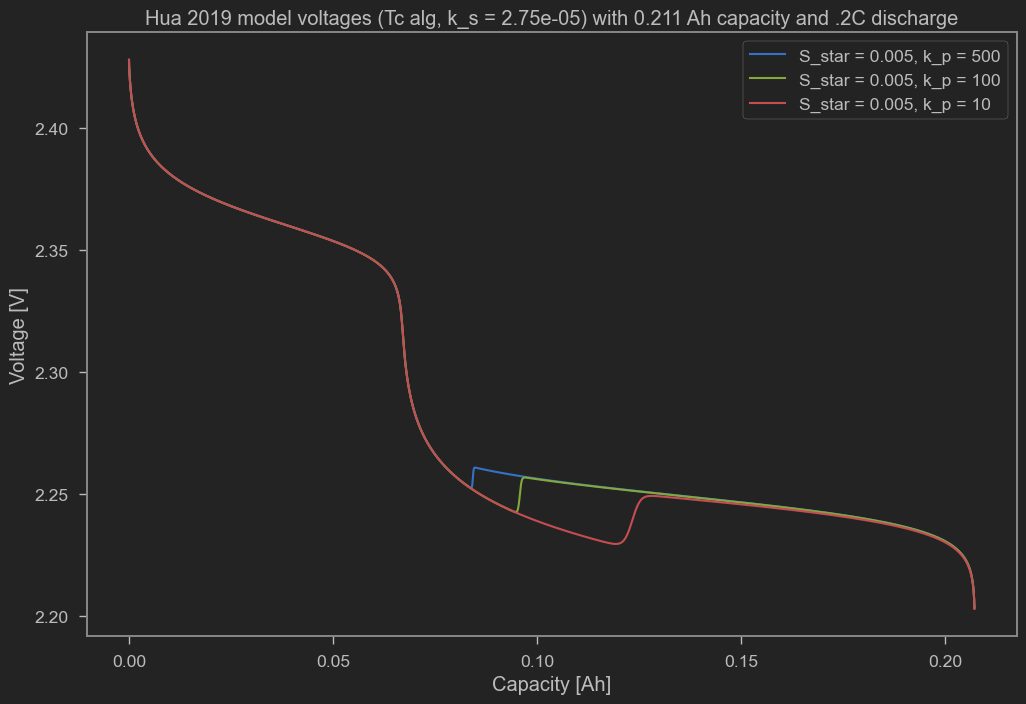

In [101]:
k_s_discharge = 2.75e-5
input_array1 = [(k_s_discharge,0.0001, 500),(k_s_discharge,0.0001, 100),(k_s_discharge,0.0001, 10)]
input_array2 = [(k_s_discharge,0.005, 500),(k_s_discharge,0.005, 100),(k_s_discharge,0.005, 10)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array2)

legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))

Text(0.5, 1.0, 'Hua 2019 model voltages (Tc alg, k_s = 0.000275) with 0.211 Ah capacity and .2C discharge')

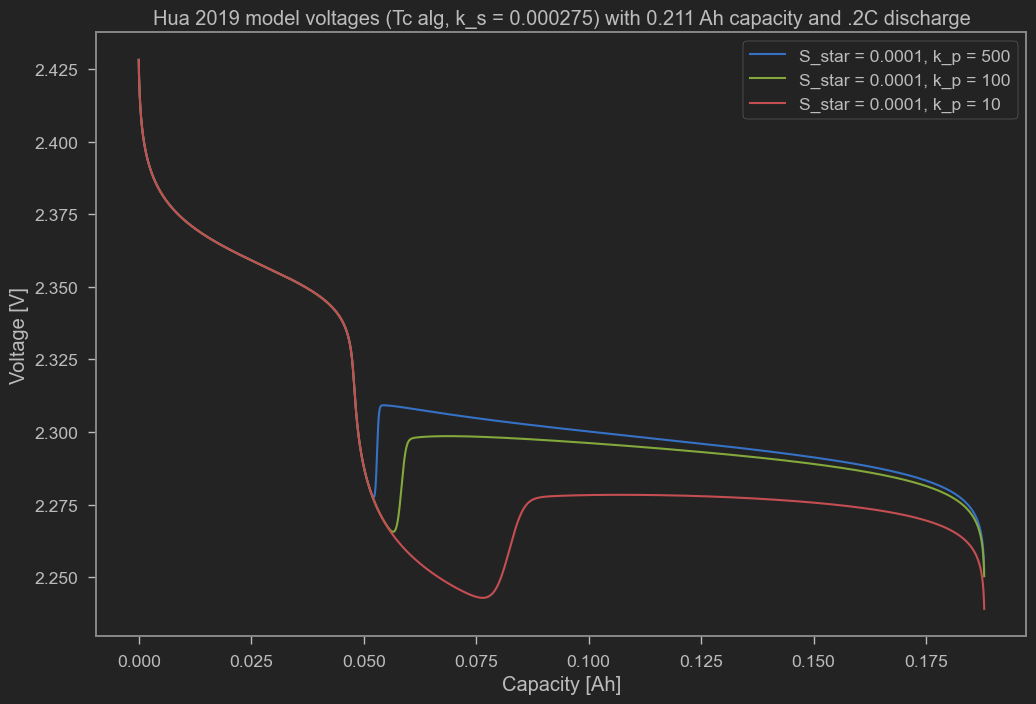

In [103]:
k_s_discharge = 2.75e-4
input_array1 = [(k_s_discharge,0.0001, 500),(k_s_discharge,0.0001, 100),(k_s_discharge,0.0001, 10)]
input_array2 = [(k_s_discharge,0.005, 500),(k_s_discharge,0.005, 100),(k_s_discharge,0.005, 10)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array1)

legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))

Text(0.5, 1.0, 'Hua 2019 model voltages (Tc alg, k_s = 0.000275) with 0.211 Ah capacity and .2C discharge')

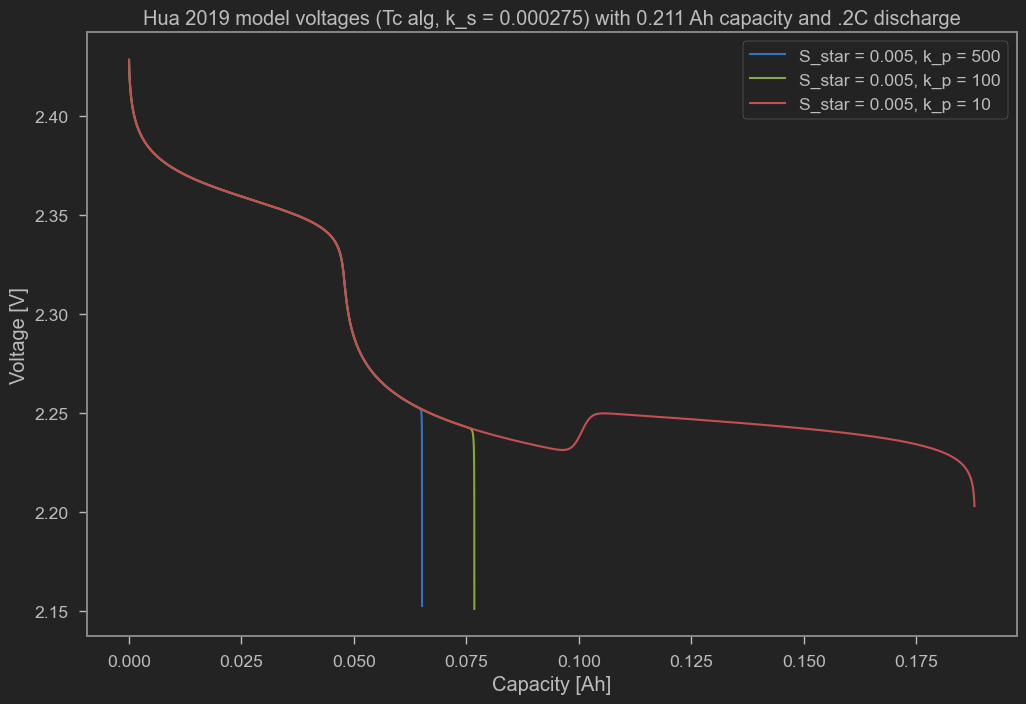

In [104]:
k_s_discharge = 2.75e-4
input_array1 = [(k_s_discharge,0.0001, 500),(k_s_discharge,0.0001, 100),(k_s_discharge,0.0001, 10)]
input_array2 = [(k_s_discharge,0.005, 500),(k_s_discharge,0.005, 100),(k_s_discharge,0.005, 10)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array2)

legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))

Text(0.5, 1.0, 'Hua 2019 model voltages (Tc alg, k_s = 0.000275) with 0.211 Ah capacity and .2C discharge')

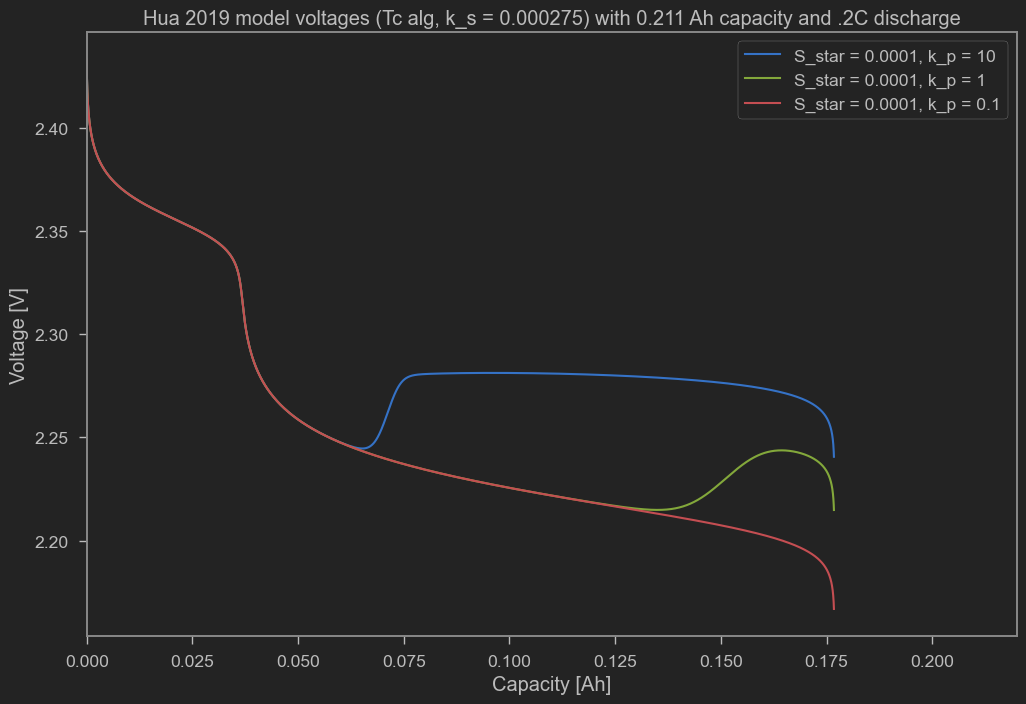

In [115]:
k_s_discharge = 2.75e-4
input_array1 = [(k_s_discharge,0.0001, 10),(k_s_discharge,0.0001, 1),(k_s_discharge,0.0001, 0.1)]
input_array2 = [(k_s_discharge,0.005, 10),(k_s_discharge,0.005, 1),(k_s_discharge,0.005, 0.1)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array1)

legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.xlim(0,.22)
#plt.ylim(1.4,2.5)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))

In [160]:
swap = 0.2
S8_initial_hunt = (S8_initial_frac-swap)*m_s_hunt
S4_initial_hunt = (S4_initial_frac+swap)*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4
initial_data = (V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt)
print(initial_data)

(2.4, 0.1335988053302967, 0.034400652715386386, 2.7097715846291745e-07, 1.020894763111026e-07, 1.6888768215181486e-07)


In [161]:
def hua_2019_alg_discharge_function(inputs):
    
    k_s_disharge, S_star, k_p = inputs
    temp = 272.15 + 30#20 # indicating the 20 degree Celcius experiment
    
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = initial_data
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 2.75e-5,
        "Shuttle rate coefficient during discharge [s-1]": k_s_discharge,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": temp,
        "Precipitation rate [s-1]": k_p,
        "S saturation mass [g]": S_star
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,10000))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = t, Ah, V, S8, S4, S2, S1, Sp, Tc, S_star, k_p
            return data
            
            break
        except:
            pass

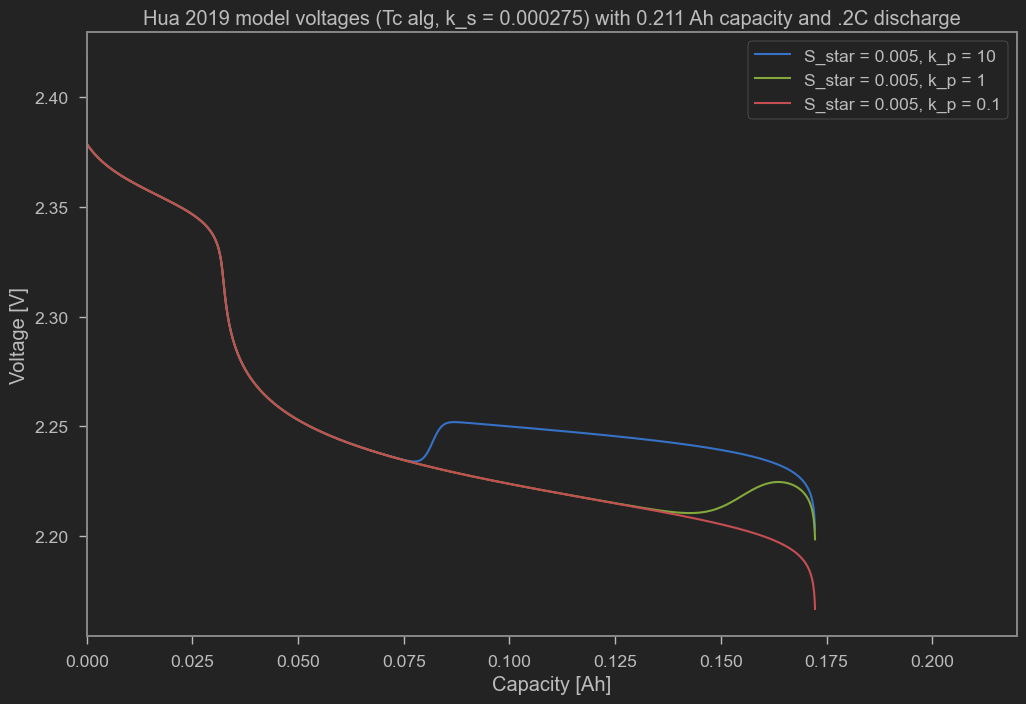

In [162]:
k_s_discharge = 2.75e-4
input_array1 = [(k_s_discharge,0.0001, 1),(k_s_discharge,0.0001, 0.5),(k_s_discharge,0.0001, 0.1)]
input_array2 = [(k_s_discharge,0.005, 10),(k_s_discharge,0.005, 1),(k_s_discharge,0.005, 0.1)]

discharge_data_kp_high = Parallel(n_jobs=-1)(delayed(hua_2019_alg_discharge_function)(i) for i in input_array2)

legend = []
for sub_data in discharge_data_kp_high:
    voltage = sub_data[2]
    Ah = sub_data[1]
    plt.plot(Ah,voltage)
    legend_str = "S_star = {}, k_p = {}".format(sub_data[-2], sub_data[-1])
    legend.append(legend_str)

        
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.legend(legend)
plt.xlim(0,.22)
#plt.ylim(1.4,2.5)
plt.title("Hua 2019 model voltages (Tc alg, k_s = {}) with 0.211 Ah capacity and .2C discharge".format(k_s_discharge))
notify